# Background

- Hypothesis: another explanation for discrepancies is that integrated gradients may flag latent components (which only activate in AND/OR circuits). For example, a later attention head may depend on an earlier one.
- Method: we run activation patching from corrupt to clean, and from clean to corrupt. We also run integrated gradients from corrupt to clean, and from clean to corrupt. AND/OR components will be flagged in integrated gradients in both directions, but only flagged in one direction for patching.
    - Clean→corrupt should pick up OR circuits, Corrupt→clean should pick up AND circuits.
    - AP asymmetry score: difference between AP scores in two directions, normalised by max score.
    - IG asymmetry score: difference between IG scores in two directions, normalised by max score.
    - AND/OR candidates should have low IG asymmetry and high AP asymmetry.

- Implications: if true, we could use IG to detect results which would have required two activation patching passes in different directions.

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from attribution_methods import integrated_gradients, activation_patching
from captum.attr import LayerIntegratedGradients


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# AND toy model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple feedforward neural network
class ANDORNet(nn.Module):
    def __init__(self):
        super(ANDORNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
    
    def run_with_cache(self, x):
        cache = {}

        # Hook function to save output
        def save_activation(name):
            def hook(module, input, output):
                cache[name] = output.detach()
            return hook

        # Register hooks
        handles = []
        for idx, layer in enumerate(self.model):
            handles.append(layer.register_forward_hook(save_activation(f"layer_{idx}")))

        # Run forward pass
        with torch.no_grad():
            output = self.forward(x)

        # Clean up hooks
        for handle in handles:
            handle.remove()

        return output, cache

In [4]:
# Training data for AND logic gate
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.tensor([[0.],
                  [0.],
                  [0.],
                  [1.]])


# Initialize the network, loss function and optimizer
and_model = ANDORNet()
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.SGD(and_model.parameters(), lr=0.1)

# Training loop
with torch.enable_grad():
    for epoch in range(1000):
        shuffle_order = torch.randperm(X.size(0))
        shuffled_X = X[shuffle_order]
        shuffled_y = y[shuffle_order]

        optimizer.zero_grad()
        outputs = and_model(shuffled_X)
        loss = criterion(outputs, shuffled_y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate model
with torch.no_grad():
    preds = and_model(X)
    print("Predictions:")
    print(preds.round())  # Round predictions to get binary output


Epoch 0, Loss: 0.7413
Epoch 100, Loss: 0.5646
Epoch 200, Loss: 0.5624
Epoch 300, Loss: 0.5623
Epoch 400, Loss: 0.5623
Epoch 500, Loss: 0.5623
Epoch 600, Loss: 0.5623
Epoch 700, Loss: 0.5623
Epoch 800, Loss: 0.5623
Epoch 900, Loss: 0.5623
Predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.]])


In [5]:
clean_input = torch.tensor([[1., 1.]], requires_grad=True)
corrupt_input = torch.tensor([[0., 0.]], requires_grad=True)
positive_output, clean_cache = and_model.run_with_cache(clean_input)
negative_output, corrupt_cache = and_model.run_with_cache(corrupt_input)

print(positive_output, clean_cache)
print(negative_output, corrupt_cache)

tensor([[0.2500]]) {'layer_0': tensor([[-0.6052, -1.3244]]), 'layer_1': tensor([[0., 0.]]), 'layer_2': tensor([[-1.0986]]), 'layer_3': tensor([[0.2500]])}
tensor([[0.2500]]) {'layer_0': tensor([[-0.0308, -0.6679]]), 'layer_1': tensor([[0., 0.]]), 'layer_2': tensor([[-1.0986]]), 'layer_3': tensor([[0.2500]])}


In [90]:
ig = LayerIntegratedGradients(and_model, and_model.model[0], multiply_by_inputs=True)
# Patch clean into corrupt
ig_and_attributions = ig.attribute(
    inputs=clean_input, baselines=corrupt_input, internal_batch_size=1
)
print(ig_and_attributions)

# Patch corrupt into clean
ig_and_attributions = ig.attribute(
    inputs=corrupt_input, baselines=clean_input, internal_batch_size=1
)
print(ig_and_attributions)

tensor([[0.4436, 0.5398]])
tensor([[-0.4436, -0.5398]])


In [89]:
def toy_activation_patching(model: nn.Module, baseline_inputs, corrupt_inputs):
    """Attribution scores for neuron A and B in layer 0."""
    n_samples = baseline_inputs.size(0)
    baseline_diff = model(baseline_inputs) - model(corrupt_inputs)
    print(f"Patch {corrupt_inputs} into {baseline_inputs}")

    # Run the model, but patch in the given value at the target layer
    attributions = torch.zeros((n_samples, 2))
    for neuron_idx in range(2):
        # Corrupt specific neuron activations
        corrupted_value = baseline_inputs.clone()
        corrupted_value[:, neuron_idx] = corrupt_inputs[:, neuron_idx]

        patch_diff = model(baseline_inputs) - model(corrupted_value)
        attributions[:, neuron_idx] = patch_diff / baseline_diff
    
    return attributions

with torch.no_grad():
    # Patch clean into corrupt
    ap_and_clean_corrupt = toy_activation_patching(and_model, corrupt_input, clean_input)
    print(f"Clean->Corrupt: {ap_and_clean_corrupt}\n")
    # Patch corrupt into clean
    ap_and_corrupt_clean = toy_activation_patching(and_model, clean_input, corrupt_input)
    print("Corrupt->Clean", ap_and_corrupt_clean)

Patch tensor([[1., 1.]], requires_grad=True) into tensor([[0., 0.]], requires_grad=True)
Clean->Corrupt: tensor([[0.0117, 0.0116]])

Patch tensor([[0., 0.]], requires_grad=True) into tensor([[1., 1.]], requires_grad=True)
Corrupt->Clean tensor([[0.9884, 0.9883]])


In the example of the AND toy model, we can see that:

- IG attributes roughly even importance (0.5) to neurons A and B. This is correct and holds for gradients in both directions (order of clean/corrupt as input/baseline only affects sign).
- Activation patching from clean ([1, 1]) to corrupt ([0, 0]) suggests that both A and B have low attribution scores, because patching either A or B does not affect the output. Denoising fails to identify the circuit components.
- Activation patching from corrupt ([0, 0]) to clean ([1, 1]) suggests that both A and B have high attribution scores, because patching either A or B affects the output.

Therefore, IG correctly identifies AND circuit components, but AP only detects AND circuit components when patching from corrupt to clean.

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training data for OR logic gate
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.tensor([[0.],
                  [1.],
                  [1.],
                  [1.]])

# Initialize the model, loss function, and optimizer
or_model = ANDORNet()
criterion = nn.BCELoss()
optimizer = optim.SGD(or_model.parameters(), lr=0.1)

# Training loop
with torch.enable_grad():
    for epoch in range(3000):
        shuffle_order = torch.randperm(X.size(0))
        shuffled_X = X[shuffle_order]
        shuffled_y = y[shuffle_order]

        optimizer.zero_grad()
        outputs = or_model(shuffled_X)
        loss = criterion(outputs, shuffled_y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate
with torch.no_grad():
    preds = or_model(X)
    print("Predictions:")
    print(preds.round())


Epoch 0, Loss: 0.6846
Epoch 100, Loss: 0.2661
Epoch 200, Loss: 0.1278
Epoch 300, Loss: 0.0806
Epoch 400, Loss: 0.0564
Epoch 500, Loss: 0.0424
Epoch 600, Loss: 0.0336
Epoch 700, Loss: 0.0277
Epoch 800, Loss: 0.0234
Epoch 900, Loss: 0.0202
Epoch 1000, Loss: 0.0177
Epoch 1100, Loss: 0.0157
Epoch 1200, Loss: 0.0142
Epoch 1300, Loss: 0.0128
Epoch 1400, Loss: 0.0117
Epoch 1500, Loss: 0.0108
Epoch 1600, Loss: 0.0100
Epoch 1700, Loss: 0.0093
Epoch 1800, Loss: 0.0087
Epoch 1900, Loss: 0.0082
Epoch 2000, Loss: 0.0077
Epoch 2100, Loss: 0.0073
Epoch 2200, Loss: 0.0069
Epoch 2300, Loss: 0.0066
Epoch 2400, Loss: 0.0063
Epoch 2500, Loss: 0.0060
Epoch 2600, Loss: 0.0057
Epoch 2700, Loss: 0.0055
Epoch 2800, Loss: 0.0052
Epoch 2900, Loss: 0.0050
Predictions:
tensor([[0.],
        [1.],
        [1.],
        [1.]])


In [96]:
clean_input = torch.tensor([[1., 1.]], requires_grad=True)
corrupt_input = torch.tensor([[0., 0.]], requires_grad=True)
positive_output, clean_cache = or_model.run_with_cache(clean_input)
negative_output, corrupt_cache = or_model.run_with_cache(corrupt_input)

print(positive_output, clean_cache)
print(negative_output, corrupt_cache)

tensor([[1.]]) {'layer_0': tensor([[5.1611, 1.2891]]), 'layer_1': tensor([[5.1611, 1.2891]]), 'layer_2': tensor([[16.9526]]), 'layer_3': tensor([[1.]])}
tensor([[0.0171]]) {'layer_0': tensor([[-0.0013, -0.0002]]), 'layer_1': tensor([[0., 0.]]), 'layer_2': tensor([[-4.0531]]), 'layer_3': tensor([[0.0171]])}


In [97]:
ig_or = LayerIntegratedGradients(or_model, or_model.model[0], multiply_by_inputs=True)
# Patch clean into corrupt
ig_or_attributions = ig_or.attribute(
    inputs=clean_input, baselines=corrupt_input, internal_batch_size=1
)
print(ig_or_attributions)

# Patch corrupt into clean
ig_or_attributions = ig_or.attribute(
    inputs=corrupt_input, baselines=clean_input, internal_batch_size=1
)
print(ig_or_attributions)

tensor([[0.8867, 0.0963]])
tensor([[-0.8867, -0.0963]])


In [98]:
with torch.no_grad():
    # Patch clean into corrupt
    ap_or_clean_corrupt = toy_activation_patching(or_model, corrupt_input, clean_input)
    print(f"Clean->Corrupt: {ap_or_clean_corrupt}\n")
    # Patch corrupt into clean
    ap_or_corrupt_clean = toy_activation_patching(or_model, clean_input, corrupt_input)
    print("Corrupt->Clean", ap_or_corrupt_clean)

Patch tensor([[1., 1.]], requires_grad=True) into tensor([[0., 0.]], requires_grad=True)
Clean->Corrupt: tensor([[0.9990, 0.9988]])

Patch tensor([[0., 0.]], requires_grad=True) into tensor([[1., 1.]], requires_grad=True)
Corrupt->Clean tensor([[0.0012, 0.0010]])


For similar reasons as the AND model, for the OR model:

- IG correctly identifies that both A and B are important.
- Activation patching from clean to corrupt also identifies A and B as important.
- Activation patching from corrupt ([0, 0]) to clean ([1, 1]) does not identify either A or B as important, because patching either neuron does not affect the OR circuit.

# AND/OR circuits in GPT2-small

In [6]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [12]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [14]:
# Patch from clean to corrupt

ig_clean_corrupt_mlp, ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ig_clean_corrupt_mlp, "saved_results/ig_clean_corrupt_mlp.pt")
torch.save(ig_clean_corrupt_attn, "saved_results/ig_clean_corrupt_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.4002e-06,  4.9453e-07,  1.5805e-06, -1.4184e-06,  4.1910e-07,
        -2.5690e-05,  2.8871e-07,  6.0908e-07,  1.3590e-05,  2.9230e-06,
         2.9686e-08,  2.1160e-06, -5.3048e-06,  8.5041e-07,  6.9942e-07,
        -2.0443e-07, -2.3842e-07, -2.5472e-07, -3.7253e-09, -2.0023e-08,
         4.5169e-07,  7.0175e-07, -9.2015e-07, -6.7055e-08,  3.6461e-07,
         2.1216e-06,  3.5395e-06,  9.7454e-06, -1.7069e-06, -8.4535e-07,
         1.5670e-06, -2.0852e-06, -7.5204e-07,  2.6850e-06, -1.1213e-06,
        -2.9784e-06, -4.6194e-07,  2.4517e-07, -1.5562e-06, -1.9139e-06,
         3.9791e-06, -2.1979e-07, -4.6566e-07, -2.0023e-06, -1.6134e-06,
         7.2829e-07,  3.4214e-06,  1.7341e-06, -6.8126e-07, -2.6822e-06,
        -1.2815e-06, -1.3581e-06, -1.5497e-06, -5.1514e-07, -1.4186e-05,
        -1.4342e-06,  4.3306e-07,  1.1039e-06, -5.0734e-07, -3.4170e-06,
         8.4820e-07, -4.5002e-06,  3.5390e-07, -1.0333e-06, -2.148

In [ ]:
ap_clean_corrupt_mlp, ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ap_clean_corrupt_mlp, "saved_results/ap_clean_corrupt_mlp.pt")
torch.save(ap_clean_corrupt_attn, "saved_results/ap_clean_corrupt_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2


In [ ]:
# Patch from corrupt to clean

ig_corrupt_clean_mlp, ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(ig_corrupt_clean_mlp, "saved_results/ig_corrupt_clean_mlp.pt")
torch.save(ig_corrupt_clean_attn, "saved_results/ig_corrupt_clean_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.8906e-07, -2.9011e-07,  8.9733e-07, -8.2795e-07, -1.2587e-06,
        -2.0266e-06, -3.3854e-07,  5.1875e-07, -1.4976e-06,  6.5146e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-1.3113e-06, -1.7695e-07, -5.3085e-07, -3.6415e-06,  2.6822e-07,
        -4.7684e-06, -3.5390e-07, -1.1399e-06,  4.7684e-06, -1.7341e-06],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 8.1258e-08, -1.3346e-06,  1.1593e-06,  3.9861e-07, -2.5816e-06,
         3.5120e-06, -2.3097e-07, -8.7428e-07,  4.7833e-06,  7.4506e-09],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-9.4093e-07,  1.0189e-06,  3.6601e-07, -7.4413e-07,  1.9632e-06,
         7.9051e-06, -2.4661e-06,  1.3015e-07,  5.9232e-06, -1.2573e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [ ]:
ap_corrupt_clean_mlp, ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(ap_corrupt_clean_mlp, "saved_results/ap_corrupt_clean_mlp.pt")
torch.save(ap_corrupt_clean_attn, "saved_results/ap_corrupt_clean_attn.pt")

In [8]:
ig_corrupt_clean_mlp = torch.load("saved_results/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("saved_results/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("saved_results/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("saved_results/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("saved_results/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("saved_results/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("saved_results/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("saved_results/ap_clean_corrupt_attn.pt")


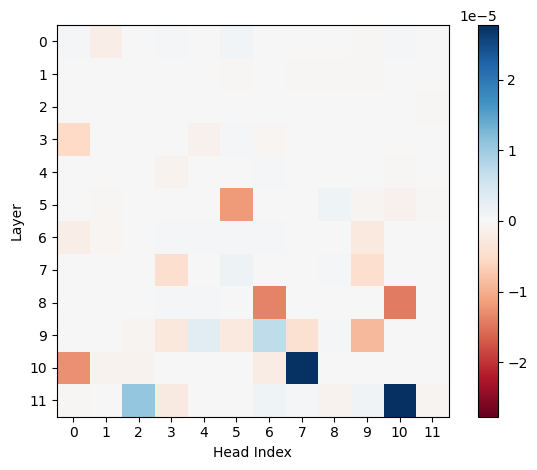

In [ ]:
from utils import plot_attn

avg_ig_clean_corrupt_mlp = ig_clean_corrupt_mlp.mean(dim=0, keepdim=True)
avg_ig_corrupt_clean_mlp = ig_corrupt_clean_mlp.mean(dim=0, keepdim=True)

avg_ap_clean_corrupt_mlp = ap_clean_corrupt_mlp.mean(dim=0, keepdim=True)
avg_ap_corrupt_clean_mlp = ap_corrupt_clean_mlp.mean(dim=0, keepdim=True)

avg_ig_clean_corrupt_attn = ig_clean_corrupt_attn.mean(dim=0, keepdim=True)
avg_ig_corrupt_clean_attn = ig_corrupt_clean_attn.mean(dim=0, keepdim=True)

avg_ap_clean_corrupt_attn = ap_clean_corrupt_attn.mean(dim=0, keepdim=True)
avg_ap_corrupt_clean_attn = ap_corrupt_clean_attn.mean(dim=0, keepdim=True)

plot_attn(avg_ig_clean_corrupt_attn, model)
plot_attn(avg_ap_clean_corrupt_attn, model)

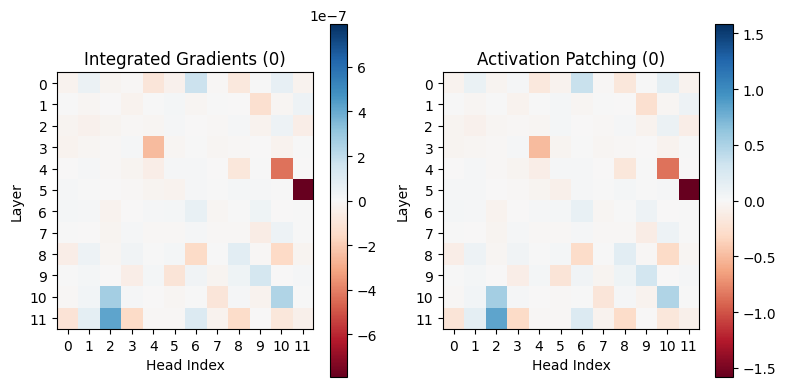

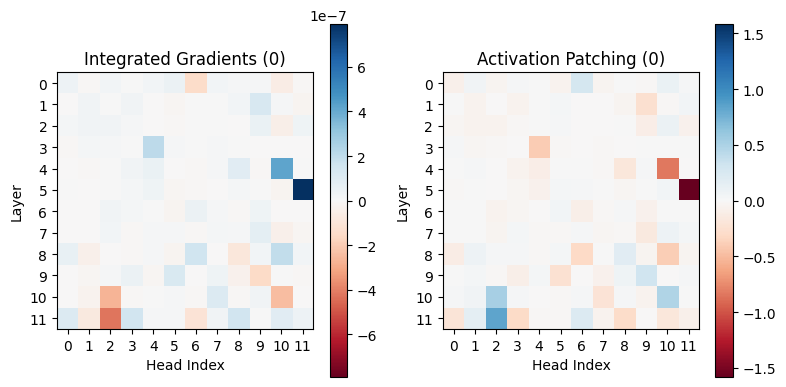

In [ ]:
# Sanity check: IG approximates AP in both directions of patching, although corrupt->clean for IG seems to be the opposite signage

plot_attn_comparison(avg_ig_clean_corrupt_attn, avg_ap_clean_corrupt_attn, Task.IOI, model)
plot_attn_comparison(avg_ig_corrupt_clean_attn, avg_ap_corrupt_clean_attn, Task.IOI, model)

In [ ]:
def asymmetry_score(corrupt_clean: torch.Tensor, clean_corrupt: torch.Tensor, is_ig: bool):
    assert corrupt_clean.shape == clean_corrupt.shape, \
        f"Cannot calculate asymmetry between matrices of different shapes, {corrupt_clean.shape} and {clean_corrupt.shape}"

    if is_ig:
        max_scores = torch.amax((clean_corrupt + corrupt_clean), dim=(1,2), keepdim=True)
        # Expect opposite directions to cancel out attribution scores
        print((corrupt_clean + clean_corrupt).shape, max_scores.shape)
        return torch.div((corrupt_clean + clean_corrupt), max_scores)
    
    max_scores = torch.amax((corrupt_clean - clean_corrupt), dim=(1,2), keepdim=True)
    return torch.div((corrupt_clean - clean_corrupt), max_scores)

ig_mlp_asymmetry = asymmetry_score(avg_ig_corrupt_clean_mlp, avg_ig_clean_corrupt_mlp, is_ig=True)
ig_attn_asymmetry = asymmetry_score(avg_ig_corrupt_clean_attn, avg_ig_clean_corrupt_attn, is_ig=True)

# The only requirement for an AND/OR circuit is high AP asymmetry
ap_mlp_asymmetry = asymmetry_score(avg_ap_corrupt_clean_mlp, avg_ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(avg_ap_corrupt_clean_attn, avg_ap_clean_corrupt_attn, is_ig=False)

torch.Size([10, 12, 3072]) torch.Size([10, 1, 1])
torch.Size([10, 12, 12]) torch.Size([10, 1, 1])


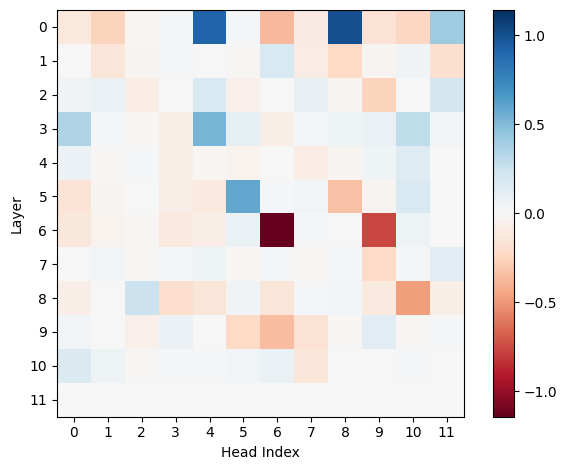

In [ ]:
from utils import plot_attn

plot_attn(ap_attn_asymmetry, model)

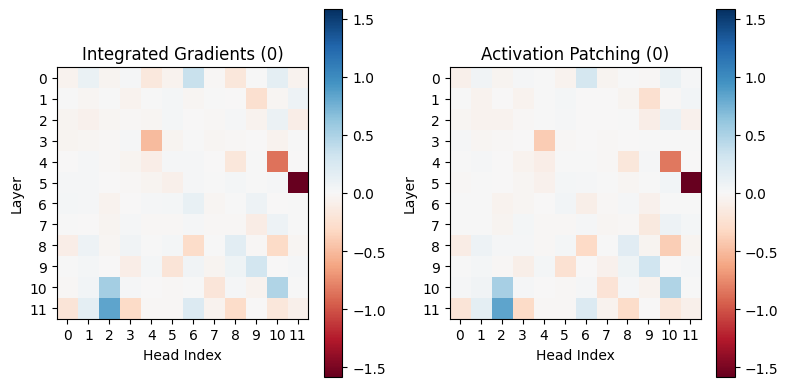

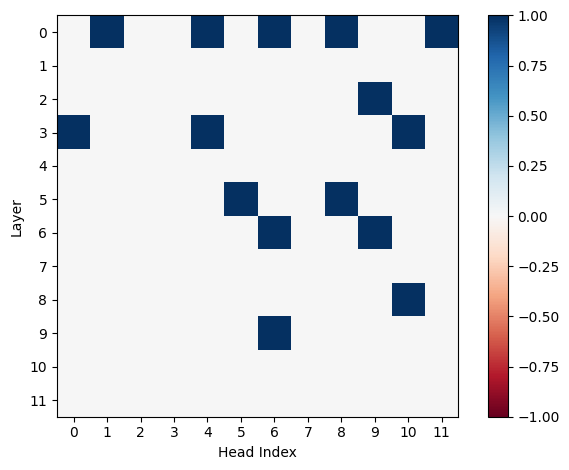

In [ ]:
plot_attn_comparison(avg_ap_clean_corrupt_attn, avg_ap_corrupt_clean_attn, Task.IOI, model)

high_ap_asymmetry = ap_attn_asymmetry.abs() > 0.25
plot_attn(high_ap_asymmetry.int(), model)

The matrix above indicates attention components which are AP asymmetric (i.e. different attribution scores for clean->corrupt and corrupt->clean patching). These components are possibly involved in AND/OR circuits.

In [37]:
# gt_mask = (ap_attn_asymmetry.abs() > ig_attn_asymmetry + 1e-2)
# zero_mask = torch.isclose(ig_attn_asymmetry, torch.zeros_like(ig_attn_asymmetry), atol=1e-4)
# mask = gt_mask & zero_mask

# plot_attn(mask[0].int(), model)

# Does IG alone highlight AND/OR components?

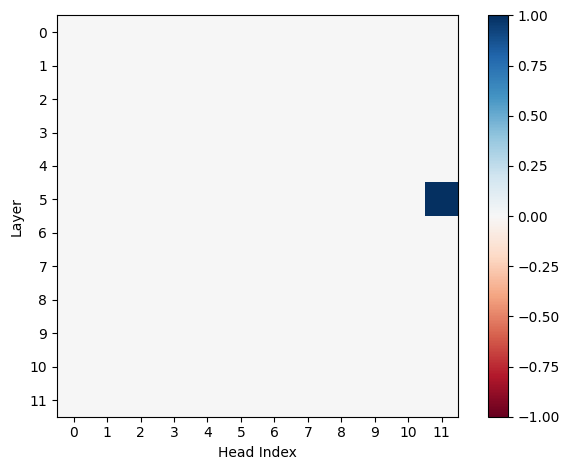

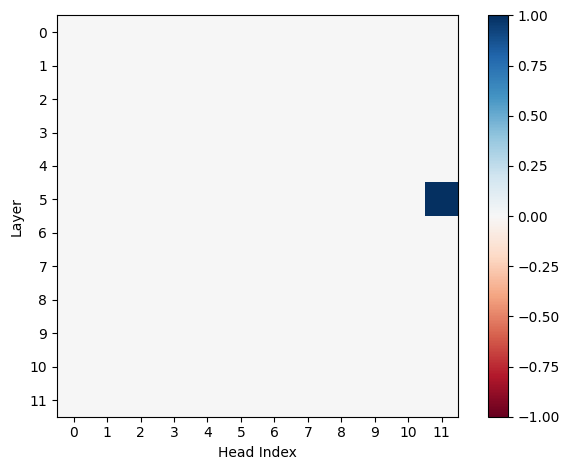

In [ ]:
ig_exclusive = asymmetry_score(avg_ig_clean_corrupt_attn, avg_ap_clean_corrupt_attn, is_ig=False)
plot_attn(ig_exclusive.int(), model)

ig_exclusive = asymmetry_score(avg_ig_corrupt_clean_attn, avg_ap_corrupt_clean_attn, is_ig=False)
plot_attn(ig_exclusive.int(), model)

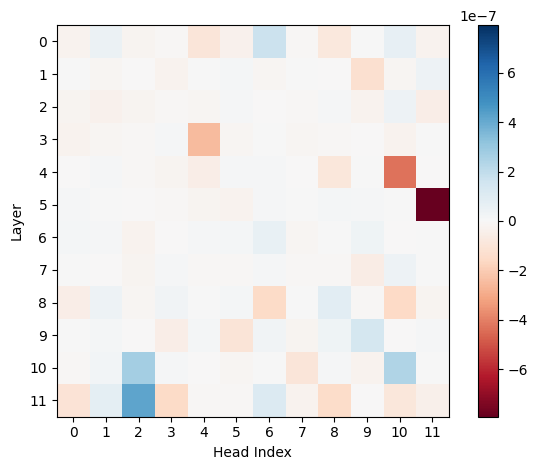

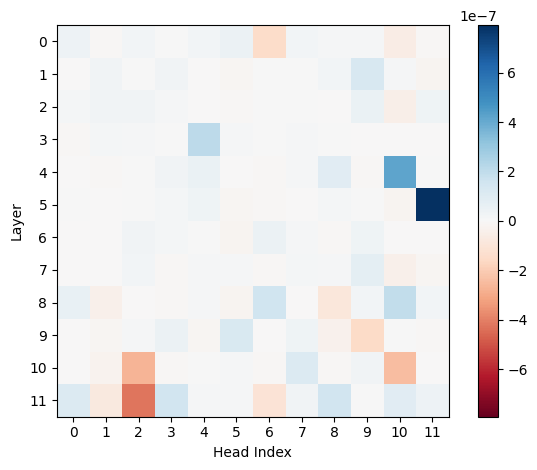

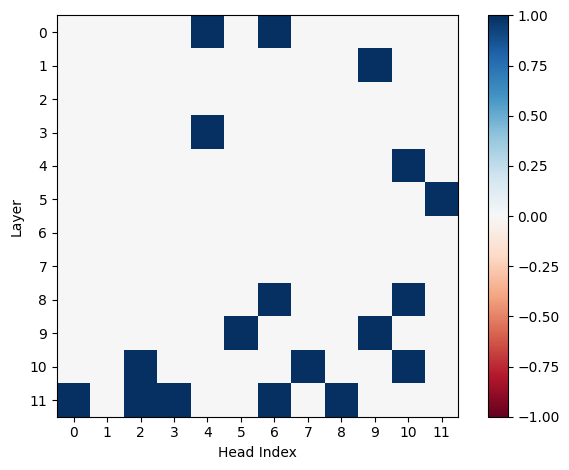

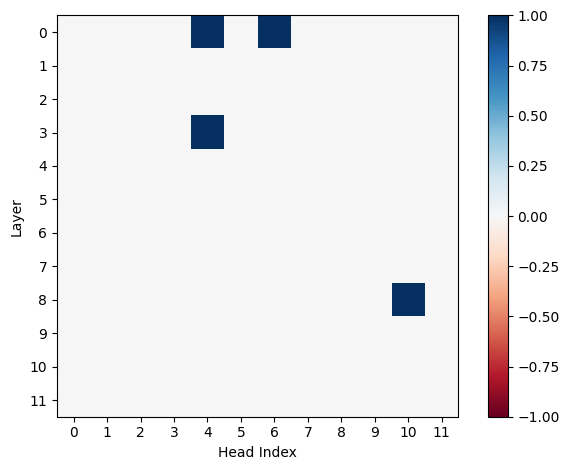

In [ ]:
mean_attn_ig = avg_ig_clean_corrupt_attn.mean()
std_attn_ig = avg_ig_clean_corrupt_attn.std()

ig_significant = avg_ig_clean_corrupt_attn.abs() > (mean_attn_ig + std_attn_ig)

plot_attn(avg_ig_clean_corrupt_attn, model)
plot_attn(avg_ig_corrupt_clean_attn, model)
plot_attn(ig_significant.int(), model)

ig_indicated_and_or = high_ap_asymmetry & ig_significant

plot_attn(ig_indicated_and_or.int(), model)

Components with high AP asymmetry scores are not really identified by IG alone. However, you can identify the same components by comparing IG with swapped baselines (i.e. approximating AP with IG).

# Verification of AND/OR circuits in GPT2-small

- Hypothesis: components with high asymmetry are latent (AND/OR circuit) components, which only affect performance if ablated alongside other components.

In [46]:
mean_corrupt_activations = dict()
for hook_name, act in corrupted_cache.cache_dict.items():
    mean_corrupt_activations[hook_name] = act.mean(dim=0)

In [ ]:
# TODO: generalise across full batch

ig_indices = ig_significant.nonzero()
# AND components: corrupt->clean detects, clean->corrupt does not detect
and_indices = (ap_attn_asymmetry > 0.25).nonzero()
# OR components: corrupt->clean does not detect, clean->corrupt detects
or_indices = (ap_attn_asymmetry < -0.25).nonzero()

In [ ]:
def run_with_ablation_attn(model, input, ablation_indices, metric, metric_labels):

    def patch_hook(act, hook, component_idx):
        corrupt_acts = mean_corrupt_activations[hook.name]
        # print(act.shape, corrupt_acts.shape, component_idx)
        act[:, :, component_idx] = corrupt_acts[:, component_idx]
        return act

    hook_tuples = []
    for layer_idx, component_idx in ablation_indices:
        hook_name = get_act_name("result", layer_idx)
        hook_fn = lambda act, hook: patch_hook(act, hook, component_idx)
        hook_tuples.append((hook_name, hook_fn))
    
    with model.hooks(fwd_hooks=hook_tuples):
        patched_logits = model(input)
    
    return metric(patched_logits, metric_labels)

For OR components, we ablate the component by itself - logit diff should not change. We then ablate all OR components / ablate all significant components / ablate all significant components and OR components, and see how performance drops.

- Ablating OR components (noising all options) should decrease performance (increased logit difference) compared to noising each OR component individually.
- Ablating OR components and significant components should maintain or decrease performance compared to just ablating significant components.

In [ ]:
for idx in or_indices:
    print(f"Analysing component {idx}...")
    # Ablate component only
    or_ablated_outputs = run_with_ablation_attn(model, clean_input, [idx], logit_diff_metric, labels)
    or_ablated_performance = or_ablated_outputs.mean()
    print(f"Average logit diff after ablating OR component only: {or_ablated_performance}")

# Ablate all OR components
all_or_ablated_outputs = run_with_ablation_attn(model, clean_input, or_indices, logit_diff_metric, labels)
all_or_ablated_performance = all_or_ablated_outputs.mean()
print(f"Average logit diff after ablating all OR components: {all_or_ablated_performance}")

# Ablate all significant components
ig_ablated_outputs = run_with_ablation_attn(model, clean_input, ig_indices, logit_diff_metric, labels)
ig_ablated_performance = ig_ablated_outputs.mean()
print(f"Average logit diff after ablating IG significant components: {ig_ablated_performance}")

# Ablate both
all_indices = torch.cat([ig_indices, or_indices])
both_ablated_outputs = run_with_ablation_attn(model, clean_input, all_indices, logit_diff_metric, labels)
both_ablated_performance = both_ablated_outputs.mean()
print(f"Average logit diff after ablating both IG significant and OR components: {both_ablated_performance}")

Analysing component tensor([0, 1])...
Average logit diff after ablating OR component only: 1.0059499740600586
Average logit diff after ablating IG significant components: 0.9629570841789246
Average logit diff after ablating both IG significant and OR components: 1.0239092111587524
Analysing component tensor([0, 6])...
Average logit diff after ablating OR component only: 0.9395541548728943
Average logit diff after ablating IG significant components: 0.9629570841789246
Average logit diff after ablating both IG significant and OR components: 0.9499115943908691
Analysing component tensor([2, 9])...
Average logit diff after ablating OR component only: 0.9118507504463196
Average logit diff after ablating IG significant components: 0.9629570841789246
Average logit diff after ablating both IG significant and OR components: 0.8761696219444275
Analysing component tensor([5, 8])...
Average logit diff after ablating OR component only: 0.9313284158706665
Average logit diff after ablating IG signifi

# Exclusive components

- Hypothesis: IG-exclusive components are meaningful components which influence model behaviour.
- Method: ablate all components which IG and AP agree on. Ablate all IG components and check performance. Ablate all AP components and check performance. We expect ablating all IG components to decrease performance more than ablating AP components.

In [ ]:
mean_attn_ig = avg_ig_corrupt_clean_attn.mean()
std_attn_ig = avg_ig_corrupt_clean_attn.std()

ig_significant = avg_ig_corrupt_clean_attn.abs() > (mean_attn_ig + std_attn_ig)
ig_attn_indices = ig_significant.nonzero()

In [ ]:
mean_attn_ap = avg_ap_corrupt_clean_attn.mean()
std_attn_ap = avg_ap_corrupt_clean_attn.std()

ap_significant = avg_ap_corrupt_clean_attn.abs() > (mean_attn_ap + std_attn_ap)
ap_attn_indices = ap_significant.nonzero()

In [ ]:
plot_attn_comparison(ig_significant, ap_significant, Task.IOI, model)

In [ ]:
# Ablate all components which IG and AP agree on
both_attn_significant = ig_significant & ap_significant
both_attn_indices = both_attn_significant.nonzero()

plot_attn(both_attn_significant, model)

agreed_outputs = run_with_ablation_attn(model, clean_input, both_attn_indices, logit_diff_metric, labels)
agreed_performance = agreed_outputs.mean()

print(f"Average logit diff after ablating all common components: {agreed_performance}")

In [ ]:
# Ablate all IG components
ig_ablated_outputs = run_with_ablation_attn(model, clean_input, ig_attn_indices, logit_diff_metric, labels)
ig_ablated_performance = ig_ablated_outputs.mean()
print(f"Average logit diff after ablating IG components: {ig_ablated_performance}")

# Ablate all AP components
ap_ablated_outputs = run_with_ablation_attn(model, clean_input, ap_attn_indices, logit_diff_metric, labels)
ap_ablated_performance = ap_ablated_outputs.mean()
print(f"Average logit diff after ablating AP components: {ap_ablated_performance}")
